In [6]:
%load_ext nb_black
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats("svg")
plt.style.use("seaborn")
import numpy as np

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

# Lecture 10
## Inferring size history using the SFS

In the last lecture we saw that the probability distribution of the number of segregating sites with $b$ copies in the sample, $q_{n,b}$, is 

$$q_{n,b} \propto \sum_{k=2}^n \frac{\binom{n-b-1}{k-2}}{\binom{n-1}{k-1}} \times k \mathbb{E}T_k.$$

## Constant $N_e$
For constant effective population size, we know that $\mathbb{E}T_k = \binom{k}{2}^{-1}$, so
\begin{align}
q_{n,b} & \propto \sum_{k=2}^n \frac{\binom{n-b-1}{k-2}}{\binom{n-1}{k-1}} \times \frac{2}{k-1} \\
        & \propto (n-b-1)! \sum_{k=2}^{n-b+1} \frac{(n-k)!}{(n-k-b+1)!} \\
        & = (n-b-1)! \sum_{k=2}^{n-b+1} \frac{(n-k)!}{(n-k-b+1)!} \\
        % & = (n-b-1)! \sum_{k=0}^{n-b-1} \frac{(k+b-1)!}{k!} \\
        & = (n-b-1)!(b-1)! \sum_{k=0}^{n-b-1} \binom{k+b-1}{k} \\
        &= (n-b-1)!(b-1)! \binom{n-1}{n-b-1}  =\frac{1}{b},
\end{align}
where the last line follows from the identity 

$$\sum_{k\le n} \binom{r+k}{k} = \binom{r+n+1}{n}.$$

## Non-constant $N_e(t)$
When population size is not constant, things become more interesting. Suppose that 

$$N_e = \begin{cases} 10,&t \le 1\\1,&\text{otherwise}. \end{cases}$$

What is $\mathbb{E} T_{n,k}$?

It is not obvious how to calculate this. The rate of coalescence now depends on time, which means that $T_{n,k}$ is no longer independent of $T_{n,k+1}$. 

The joint PDF of $\mathbf{T}_n = (T_{n,2},\dots,T_{n,n})$ is

$$f(t_2,\dots,t_n) = \prod_{k=2}^n \frac{\binom{k}{2}}{N_e(t_k)} \exp \Big( - \int_{t_{k+1}}^{t_k} \frac{\binom{k}{2}}{N_e(u)}\,du \Big)$$

for $0=t_{n+1} < t_n < \cdots < t_2$.

## First coalescent times
It turns out that the vector 

$$E\mathbf{T}_n = (\mathbb{E}T_{n,2},\dots,\mathbb{E}T_{n,n})^T$$ 

is linearly related to the vector of *first coalescent times* $(\mathbb{E}T_{2,2}, \dots, \mathbb{E}T_{n,n})^T$. The pdf of $T_{jj}$ has the simpler form 

$$q_j(t_j) = \frac{a_j}{N_e(t_j)} \exp \Big( - \int_0^{t_j} \frac{a_j}{N_e(u)}\,du \Big)$$ 

where $a_j=\binom{j}{2}.$ So we can easily compute $\mathbb{E}T_{jj}$.

*Proof*. Define the integral transform 

$$\Psi p(s) = \int_0^\infty p(t) \exp \Big(-s \int_0^t \frac{du}{N_e(u)} \Big) \,dt.$$

Then $\Psi q_j(s) = a_j/(a_j+s)$.

If we apply this transform to the marginal distribution $\pi_k(t_k) = \idotsint f(t_k,\dots,t_n) \, dt_n\cdots dt_{k+1}$, it can be shown by a somewhat messy repeated integration that

$$ \Psi \pi_k(s) = \prod_{j=k}^n \frac{a_j}{s+a_j}.$$

The product can be expanded in partial fractions:

\begin{align}
\prod_{j=k}^n \frac{a_j}{s+a_j} &= \prod_{j=k}^n \frac{a_j}{Q(s)} = \sum_{j=k}^n \frac{\prod_\ell a_\ell}{Q'(-a_j)} \cdot \frac{1}{s+a_j}\\ &= 
\sum_{j=k}^n \frac{\prod_\ell a_\ell}{\prod_{\ell \neq j} a_\ell - a_j }\cdot \frac{1}{s+a_j}  \\
&= \sum_{j=k}^n A_{j,k}^{(n)} \frac{a_j}{s+a_j}
\end{align}

for appropriately defined $A_{j,k}^{(n)}$. 

So we find that $$\Psi \lambda_k = \sum_{j=k}^n A_{j,k}^{(n)} \Psi q_j.$$

Since $\Psi$ is linear, so is its inverse, so this proves the result.

In particular, we have that $$\mathbb{E}{T_{n,k}} = \sum_{j=k}^n A_{j,k}^{(n)} \mathbb{E}T_{jj}.$$

Are we done? Not quite.

In [12]:
def a(j):
    return j * (j - 1) // 2


def A(n):
    return np.array(
        [
            [
                np.prod(
                    [a(ell) / (a(ell) - a(j)) for ell in range(k, n + 1) if ell != j]
                )
                * (j >= k)
                for j in range(2, n + 1)
            ]
            for k in range(2, n + 1)
        ]
    )

<IPython.core.display.Javascript object>

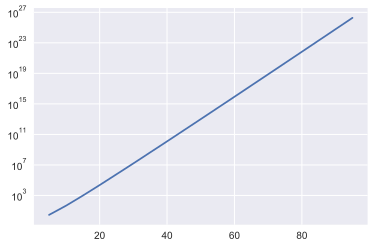

<IPython.core.display.Javascript object>

In [16]:
k = np.arange(5, 100, 5)
plt.plot(k, [abs(A(kk)).max() for kk in k])
plt.yscale("log")

## A magical result
It turns out, magically, that although $\mathbb{E}T_{n,k}$ is not numerically stable, computing $q_{n,b}$ *is*. Specifically, there is exists a numerically stable matrix $W$ such that 

$$\mathbf{q}_n = \mathbf{W} \cdot (\mathbb{E}T_{22},\dots,\mathbb{E}T_{nn})^T.$$

In [22]:
import functools


@functools.lru_cache(None)
def _W(n, b, j):
    if j == 2:
        return 6.0 / (n + 1)
    elif j == 3:
        return 30.0 * (n - 2 * b) / (n + 1) / (n + 2)
    else:
        jj = j - 2
        ret = (
            _W(n, b, jj)
            * (-(1 + jj) * (3 + 2 * jj) * (n - jj))
            / (jj * (2 * jj - 1) * (n + jj + 1))
        )
        ret += _W(n, b, jj + 1) * (3 + 2 * jj) * (n - 2 * b) / (jj * (n + jj + 1))
        return ret


def W(n):
    return np.array([[_W(n, b, j) for j in range(2, n + 1)] for b in range(1, n)])

<IPython.core.display.Javascript object>

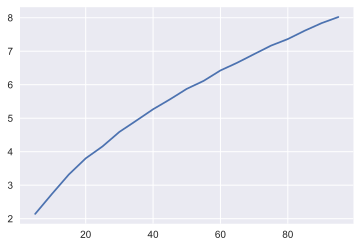

<IPython.core.display.Javascript object>

In [23]:
plt.plot(k, [abs(W(kk)).max() for kk in k])

In [25]:
# Verify that it produces the correct result for constant Ne
n = 20
j = np.arange(2, n + 1)
W(n) @ (2 / j / (j - 1))

array([2.        , 1.        , 0.66666667, 0.5       , 0.4       ,
       0.33333333, 0.28571429, 0.25      , 0.22222222, 0.2       ,
       0.18181818, 0.16666667, 0.15384615, 0.14285714, 0.13333333,
       0.125     , 0.11764706, 0.11111111, 0.10526316])

<IPython.core.display.Javascript object>

## Inference
Given a function $N_e(t)$, we can compute $q_{n,b}$.

In [26]:
from scipy.integrate import quad
from scipy.interpolate import PPoly


<IPython.core.display.Javascript object>

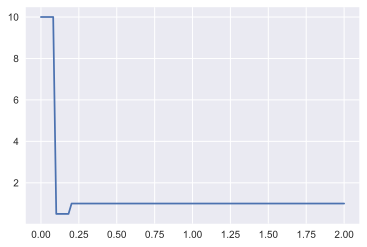

<IPython.core.display.Javascript object>

In [32]:
Ne = PPoly(x=[0.0, 0.1, 0.2, np.inf], c=[[10.0, 0.5, 1.0]])
x = np.linspace(0, 2, 100)
plt.plot(x, Ne(x))

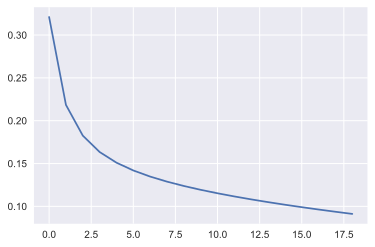

<IPython.core.display.Javascript object>

In [46]:
def ETjj(Ne, n):
    R = Ne.antiderivative()
    ret = np.array(
        [quad(lambda x: np.exp(-a(j) * R(x)), 0.0, np.inf)[0] for j in range(2, n + 1)]
    )
    return ret


n = 20
E = ETjj(Ne, n)
plt.plot(W(n) @ E)